# TDS Project: Part 3 - Research Project

# Automated Transformation and Balancing for Skewed and Imbalanced Datasets

### Imports

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

In [76]:
files = {
    #"Loan Dataset": "loan.csv",
    #"Medical Appointments No Shows": "KaggleV2-May-2016.csv",
    #"Bank Marketing": "bank-additional-full.csv",
    "Telco Customer Churn": "WA_Fn-UseC_-Telco-Customer-Churn.csv"
}
# To handle imbalanced data
!pip install imbalanced-learn --quiet
from imblearn.over_sampling import SMOTE

# For normality tests (optional usage)
from scipy.stats import skew, shapiro

You should consider upgrading via the 'C:\Users\guyha\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [77]:
data_path = "WineQT.csv"
df = pd.read_csv(data_path)

print("Initial Shape of the Data:", df.shape)
print("\nSample Rows:")
display(df.head())

print("\nData Info:")
df.info()

Initial Shape of the Data: (1143, 13)

Sample Rows:


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


Basic Data Cleaning

In [78]:
if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)
    print("\n'Dropped Id column. Current columns:", df.columns.tolist())
missing_values = df.isnull().sum()
print("\nMissing Values in Each Column:\n", missing_values)



'Dropped Id column. Current columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Missing Values in Each Column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


# Step 3: Convert 'quality' into a Binary Target

In [79]:
threshold = 7
df['quality_label'] = (df['quality'] >= threshold).astype(int)

# We can drop the original "quality" or keep it for reference
df.drop(columns=['quality'], inplace=True)

print("\nDistribution of New Target (quality_label):")
print(df['quality_label'].value_counts())


Distribution of New Target (quality_label):
quality_label
0    984
1    159
Name: count, dtype: int64


# Step 4: Exploratory Data Analysis (EDA)

In [80]:
print("\n--- Basic Statistical Description ---\n")
display(df.describe())


--- Basic Statistical Description ---



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_label
count,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000,1143.000000
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,0.139108
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.346210
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,0.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,0.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,0.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,1.000000


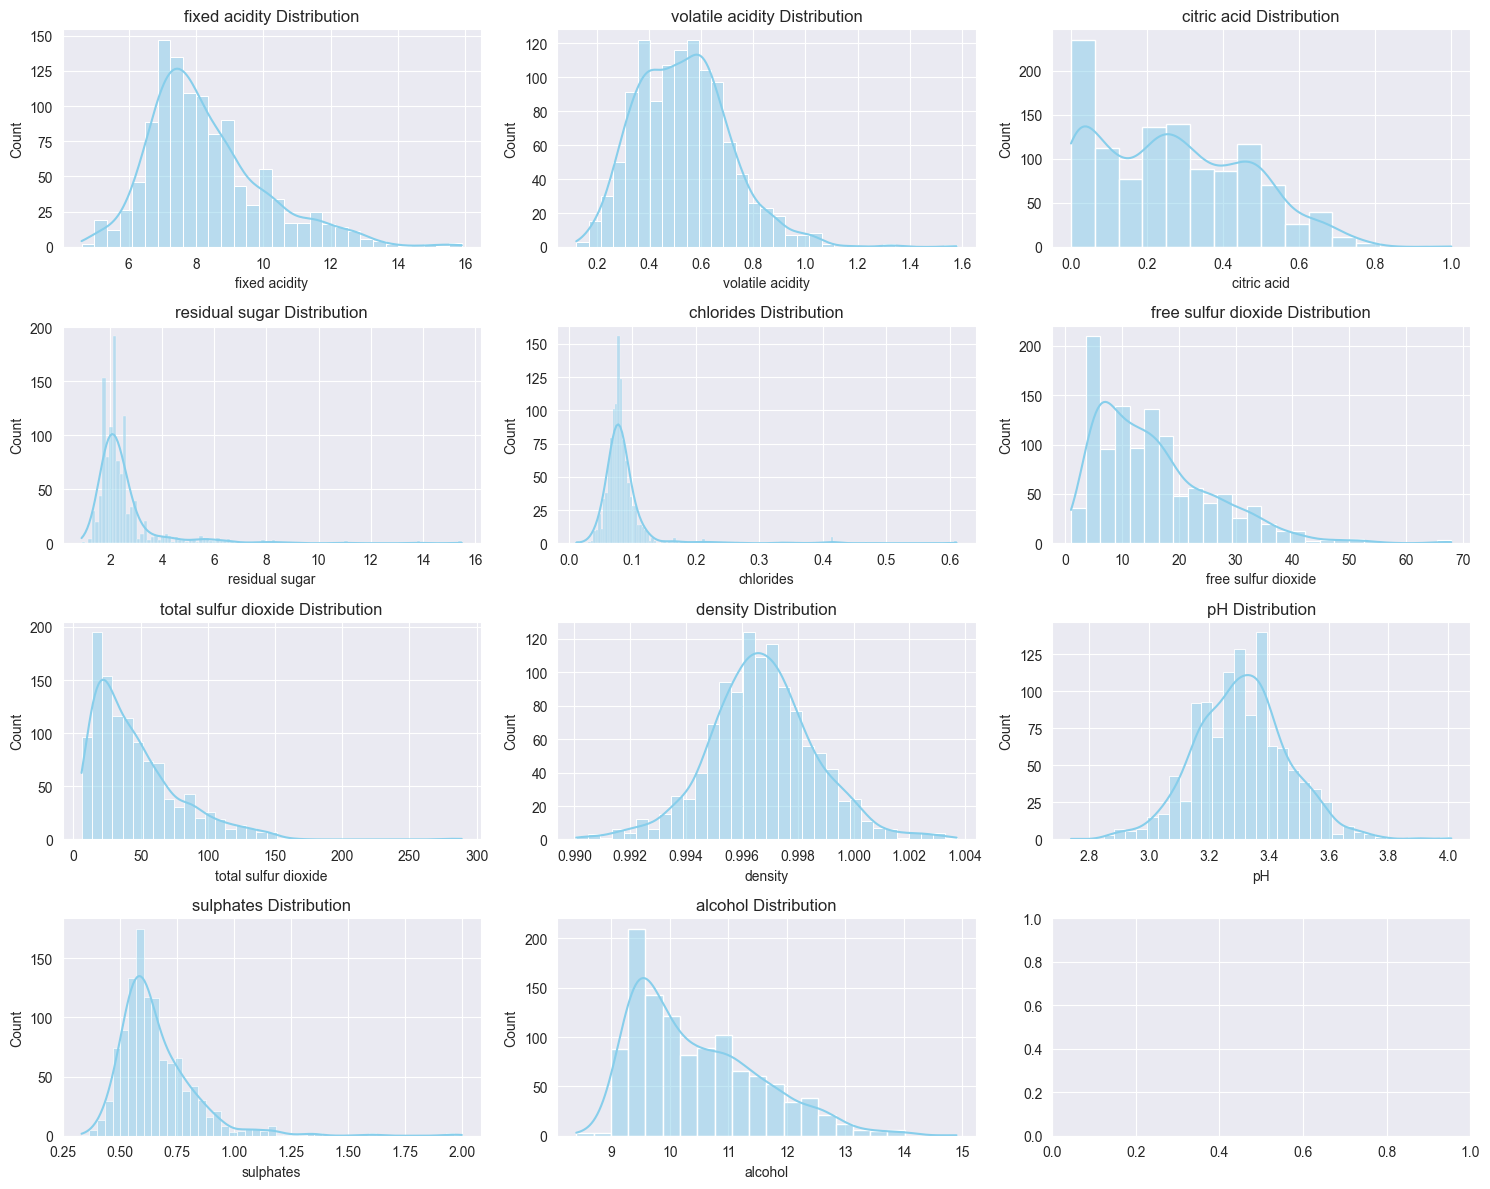


--- Skewness of Each Numeric Feature ---
fixed acidity: skew = 1.044
volatile acidity: skew = 0.681
citric acid: skew = 0.371
residual sugar: skew = 4.355
chlorides: skew = 6.018
free sulfur dioxide: skew = 1.230
total sulfur dioxide: skew = 1.664
density: skew = 0.102
pH: skew = 0.221
sulphates: skew = 2.494
alcohol: skew = 0.862


In [81]:
numeric_cols = df.drop(columns=['quality_label']).columns

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15,12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"{col} Distribution")
plt.tight_layout()
plt.show()

# Calculate and display skewness
print("\n--- Skewness of Each Numeric Feature ---")
for col in numeric_cols:
    sk_val = skew(df[col].dropna())
    print(f"{col}: skew = {sk_val:.3f}")

# Step 5: Automatic Skewness Correction
#############################################
# We'll define a simple function that tries log, sqrt, or no transform
# and picks the transform that yields the lowest absolute skewness.
# NOTE: This is a simplistic approach. You can incorporate Shapiro test
# or other tests if you want a more robust selection.

In [82]:
def best_transform_for_column(series):
    """
    Returns a tuple: (transformed_series, chosen_transform_name)
    Among: 'none', 'log', 'sqrt'
    Only applies if series values are positive (for log/sqrt).
    """
    # If the column has non-positive values, we skip log/sqrt for safety
    possible_transforms = ['none']
    if (series > 0).all():
        possible_transforms.extend(['log', 'sqrt'])

    best_skew = float('inf')
    best_data = series
    best_method = 'none'

    for method in possible_transforms:
        if method == 'none':
            transformed = series
        elif method == 'log':
            transformed = np.log1p(series)  # log(1+x) safe for zero
        elif method == 'sqrt':
            transformed = np.sqrt(series)

        current_skew = abs(skew(transformed.dropna()))
        if current_skew < best_skew:
            best_skew = current_skew
            best_method = method
            best_data = transformed

    return best_data, best_method


def transform_skewed_features(df, skew_threshold=0.75):
    """
    For each numeric column with abs(skew) > skew_threshold,
    find the best transform among none/log/sqrt
    and apply it. Returns a new DataFrame and a dict of chosen transforms.
    """
    df_transformed = df.copy()
    chosen_methods = {}

    for col in df_transformed.columns:
        if col == 'quality_label':
            continue  # skip the target
        # Check skew
        col_skew = skew(df_transformed[col].dropna())
        if abs(col_skew) > skew_threshold:
            # Attempt best transform
            new_col_data, method = best_transform_for_column(df_transformed[col])
            df_transformed[col] = new_col_data
            chosen_methods[col] = method
        else:
            chosen_methods[col] = 'none'

    return df_transformed, chosen_methods

# Let's apply transformation with a chosen threshold
skew_threshold = 0.75
df_transformed, transform_choices = transform_skewed_features(
    df.drop(columns=['quality_label']),
    skew_threshold=skew_threshold
)

df_transformed['quality_label'] = df['quality_label']  # re-attach label

print("\nChosen Transform for Each Feature:")
for feature, method in transform_choices.items():
    print(f"  {feature} -> {method}")

# Show new skewness
print("\n--- NEW Skewness After Transformation ---")
for col in numeric_cols:
    col_skew = skew(df_transformed[col].dropna())
    print(f"{col}: skew = {col_skew:.3f}")



Chosen Transform for Each Feature:
  fixed acidity -> log
  volatile acidity -> none
  citric acid -> none
  residual sugar -> log
  chlorides -> sqrt
  free sulfur dioxide -> log
  total sulfur dioxide -> log
  density -> none
  pH -> none
  sulphates -> sqrt
  alcohol -> log

--- NEW Skewness After Transformation ---
fixed acidity: skew = 0.483
volatile acidity: skew = 0.681
citric acid: skew = 0.371
residual sugar: skew = 2.156
chlorides: skew = 3.841
free sulfur dioxide: skew = -0.092
total sulfur dioxide: skew = 0.003
density: skew = 0.102
pH: skew = 0.221
sulphates: skew = 1.619
alcohol: skew = 0.675


# Step 6: Check and Handle Class Imbalance


In [83]:
# 6.1 Check distribution of target
class_counts = df_transformed['quality_label'].value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

print(f"\nClass Distribution:\n{class_counts}")
imbalance_ratio = class_counts[majority_class] / class_counts[minority_class]
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

# For demonstration, let's define > 1.5 as "imbalanced"
if imbalance_ratio > 1.5:
    print("\nWe have an imbalanced dataset. Will apply SMOTE oversampling.\n")

    # Separate features & target
    X = df_transformed.drop(columns=['quality_label'])
    y = df_transformed['quality_label']

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    print("Before SMOTE: ", pd.Series(y_train).value_counts())

    # Apply SMOTE
    sm = SMOTE(random_state=42)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

    print("After SMOTE: ", pd.Series(y_train_sm).value_counts())

else:
    print("\nDataset is not significantly imbalanced. Proceeding without SMOTE.\n")

    # Train-Test Split
    X = df_transformed.drop(columns=['quality_label'])
    y = df_transformed['quality_label']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    X_train_sm, y_train_sm = X_train, y_train  # no change


Class Distribution:
quality_label
0    984
1    159
Name: count, dtype: int64
Imbalance Ratio: 6.19

We have an imbalanced dataset. Will apply SMOTE oversampling.

Before SMOTE:  quality_label
0    689
1    111
Name: count, dtype: int64
After SMOTE:  quality_label
0    689
1    689
Name: count, dtype: int64


#############################################
# Step 7: Model Training & Evaluation
#############################################

# 7.1 Baseline Model (No Transform, No SMOTE) for Comparison
# We'll do a quick comparison by also training on the raw data


In [84]:
# 7.1.1 Prepare the raw data (no transform, no SMOTE)
X_raw = df.drop(columns=['quality_label'])
y_raw = df['quality_label']

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_raw, test_size=0.3, random_state=42, stratify=y_raw
)

# Baseline model
lr_baseline = LogisticRegression(max_iter=1000)
lr_baseline.fit(X_train_raw, y_train_raw)
y_pred_base = lr_baseline.predict(X_test_raw)

print("=== Baseline Model (No Transform / No SMOTE) ===")
print("Balanced Accuracy:", balanced_accuracy_score(y_test_raw, y_pred_base))
print(classification_report(y_test_raw, y_pred_base, digits=3))

# 7.2 Our Proposed Model (Transformed Features + SMOTE if needed)
lr_proposed = LogisticRegression(max_iter=1000)
lr_proposed.fit(X_train_sm, y_train_sm)
y_pred_proposed = lr_proposed.predict(X_test)

print("\n=== Proposed Model (Transformed + SMOTE if applied) ===")
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_proposed))
print(classification_report(y_test, y_pred_proposed, digits=3))

=== Baseline Model (No Transform / No SMOTE) ===
Balanced Accuracy: 0.620409604519774
              precision    recall  f1-score   support

           0      0.892     0.949     0.920       295
           1      0.483     0.292     0.364        48

    accuracy                          0.857       343
   macro avg      0.687     0.620     0.642       343
weighted avg      0.834     0.857     0.842       343


=== Proposed Model (Transformed + SMOTE if applied) ===
Balanced Accuracy: 0.731638418079096
              precision    recall  f1-score   support

           0      0.936     0.797     0.861       295
           1      0.348     0.667     0.457        48

    accuracy                          0.778       343
   macro avg      0.642     0.732     0.659       343
weighted avg      0.854     0.778     0.804       343



#############################################
# Step 8: Visual Comparisons
#############################################

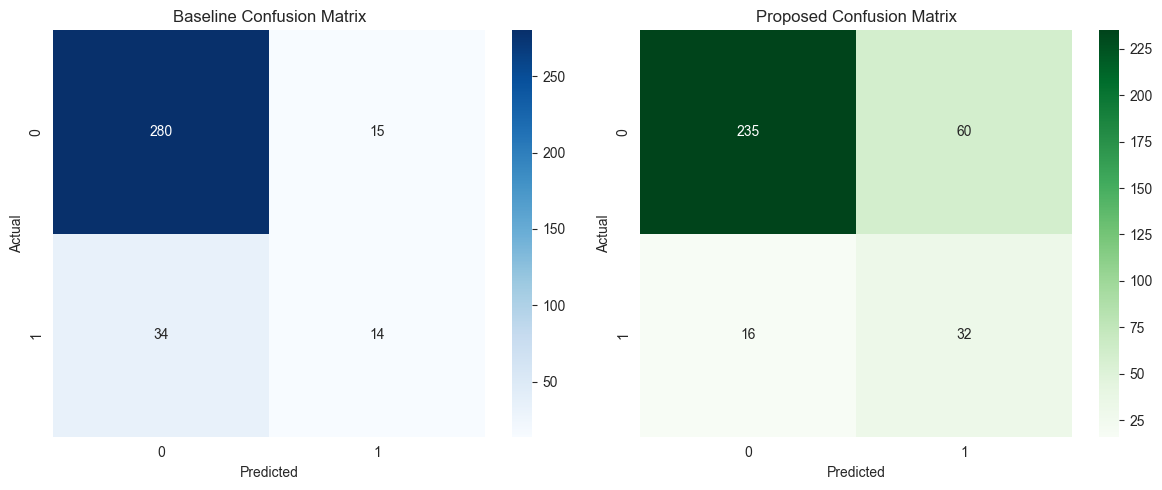

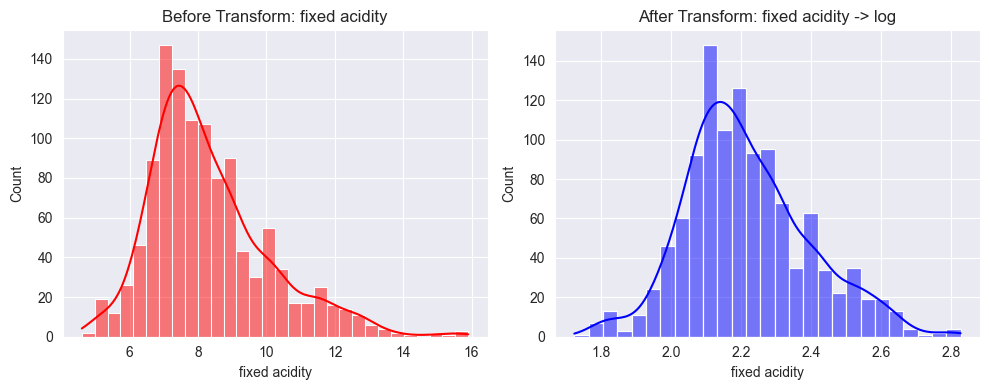

In [85]:
# 8.1 Confusion Matrices for Baseline vs Proposed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Baseline
cm_base = confusion_matrix(y_test_raw, y_pred_base)
sns.heatmap(cm_base, annot=True, fmt='d', ax=ax1, cmap="Blues")
ax1.set_title("Baseline Confusion Matrix")
ax1.set_xlabel("Predicted"); ax1.set_ylabel("Actual")

# Proposed
cm_prop = confusion_matrix(y_test, y_pred_proposed)
sns.heatmap(cm_prop, annot=True, fmt='d', ax=ax2, cmap="Greens")
ax2.set_title("Proposed Confusion Matrix")
ax2.set_xlabel("Predicted"); ax2.set_ylabel("Actual")

plt.tight_layout()
plt.show()

# 8.2 Skewness Reduction for One Example Feature
# Let's pick a feature that was highly skewed and show before vs after
sample_feature = None
for feature, method in transform_choices.items():
    if method != 'none':
        sample_feature = feature
        break

if sample_feature:
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(10,4))

    sns.histplot(df[sample_feature], kde=True, ax=ax3, color='red')
    ax3.set_title(f"Before Transform: {sample_feature}")

    sns.histplot(df_transformed[sample_feature], kde=True, ax=ax4, color='blue')
    ax4.set_title(f"After Transform: {sample_feature} -> {transform_choices[sample_feature]}")
    plt.tight_layout()
    plt.show()
else:
    print("\nNo feature was transformed. Skewness was below threshold.")

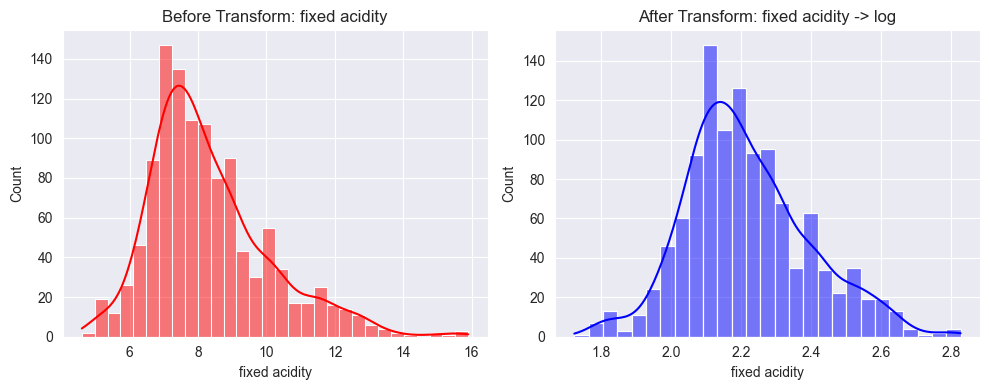

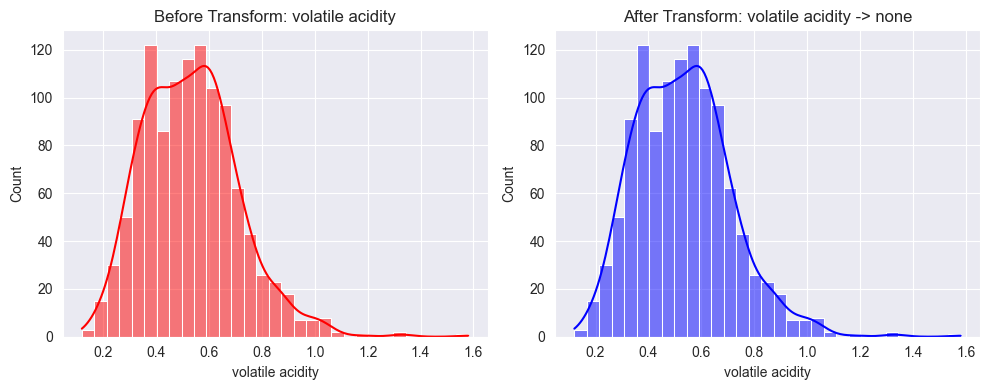

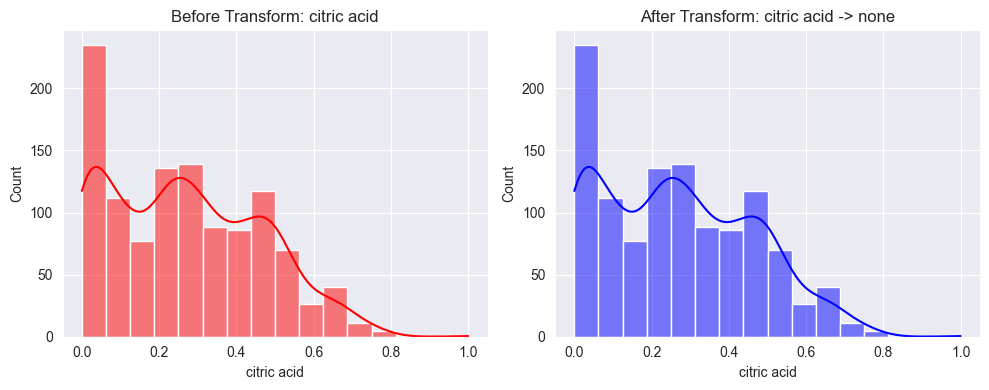

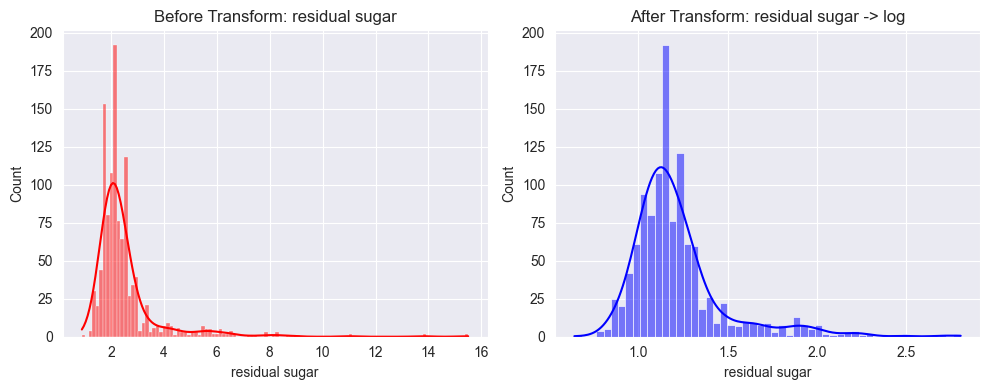

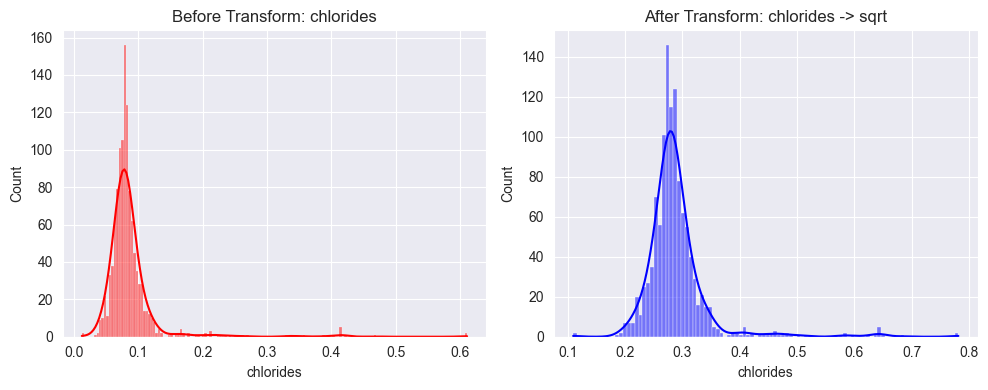

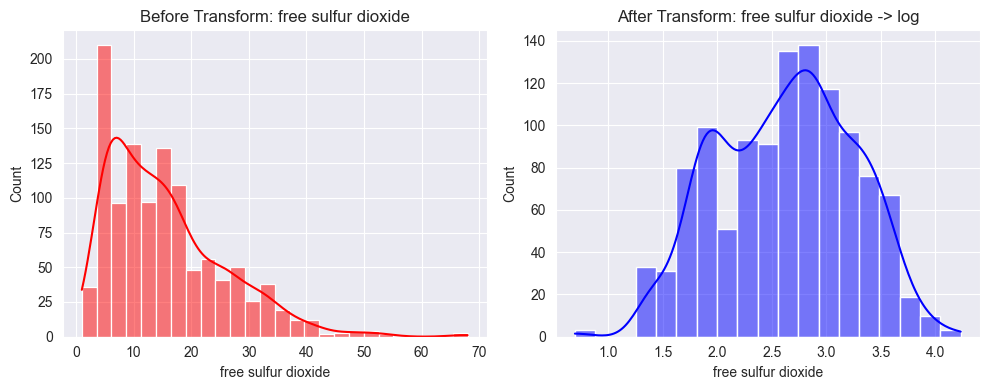

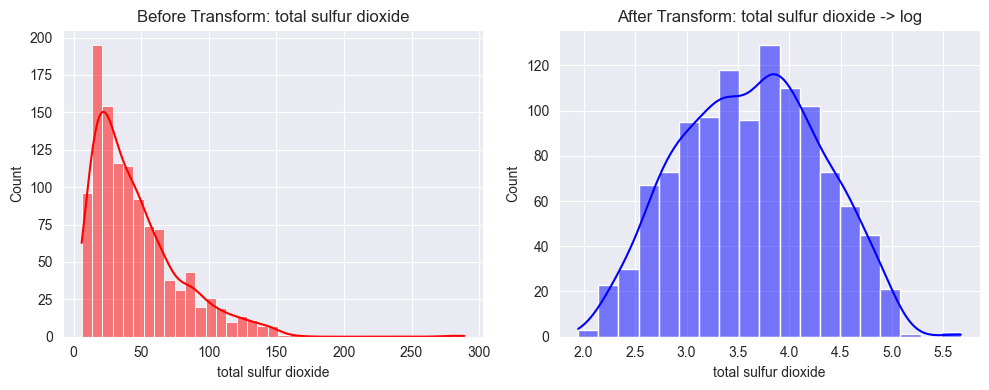

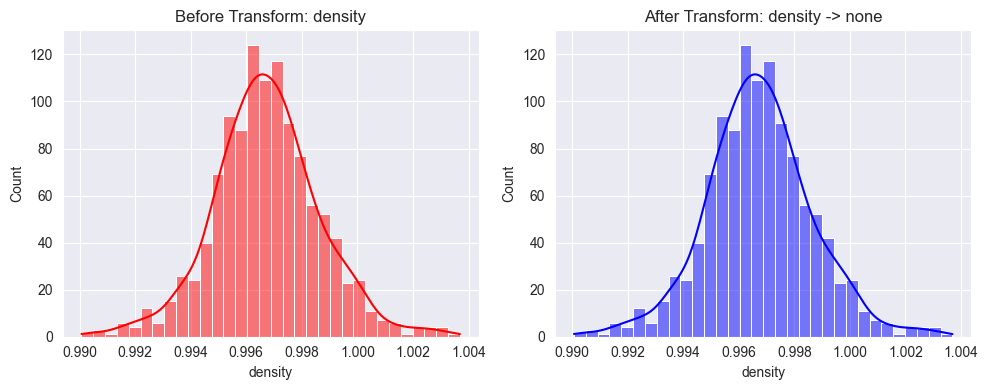

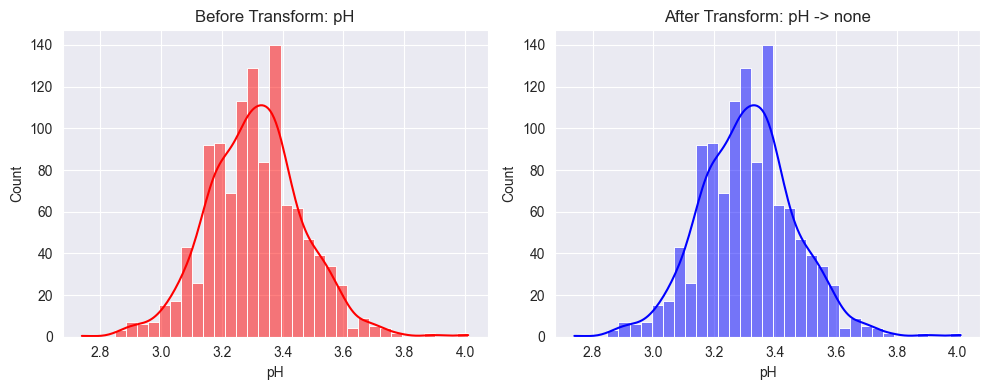

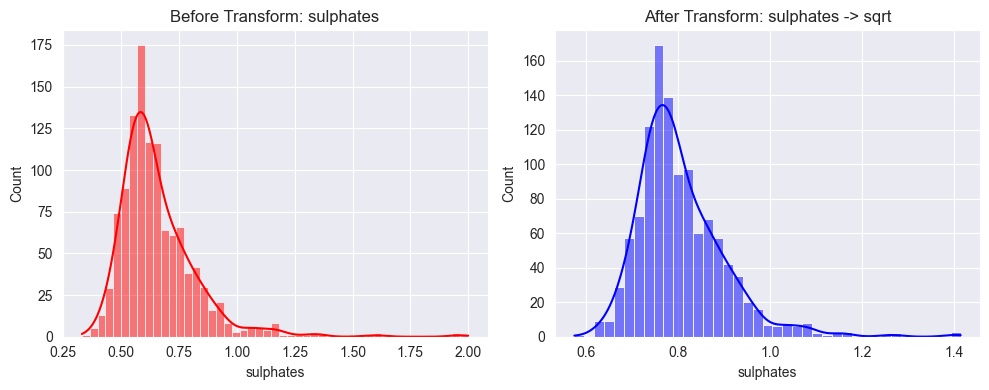

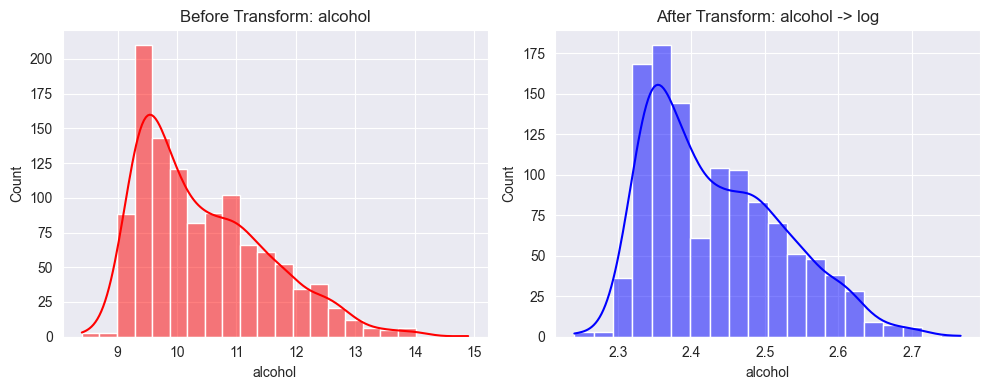

In [86]:
# 8.3 Skewness Reduction for All Features - Before vs After

numeric_cols = df.drop(columns=['quality_label']).columns  # Exclude target variable

for col in numeric_cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Before Transformation
    sns.histplot(df[col], kde=True, ax=ax1, color='red')
    ax1.set_title(f"Before Transform: {col}")

    # After Transformation
    sns.histplot(df_transformed[col], kde=True, ax=ax2, color='blue')
    ax2.set_title(f"After Transform: {col} -> {transform_choices[col]}")

    plt.tight_layout()
    plt.show()
